# Setup

In [1]:
import scanpy as sc
import numpy as np
import re
import os
import pandas as pd
import seaborn as sb
import matplotlib

import matplotlib as mpl
from scipy import stats as scistats
import matplotlib.pyplot as pl
import scanpy.external as sce
from matplotlib import colors
import bbknn
from pathlib import Path
sc._settings.ScanpyConfig.n_jobs=8

pl.rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=False,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')
colorsComb = np.vstack([pl.cm.Reds(np.linspace(0, 1, 10)), pl.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

import muon as mu
# Import a module with ATAC-seq-related functions
from muon import atac as ac

%matplotlib inline
import panel as pn
#pn.extension(sizing_mode="stretch_width", comms='colab')
pn.extension( comms='colab')


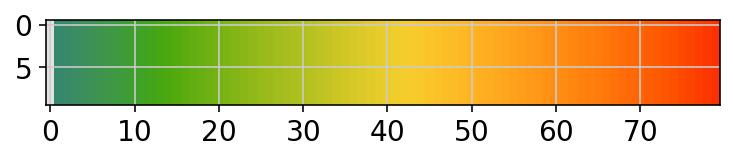

In [2]:
import colorcet as cc

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.8,0.1, 1)), cc.cm.rainbow_bgyr_35_85_c72(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
pl.imshow(xs, cmap=mymap);  # use tab completion to choose

In [3]:
# add extra code to the path
import sys
sys.path.append('/content/sctoolkit/sctoolkit/')
from proportions import *

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


In [4]:
%load_ext watermark
%watermark
%watermark --iversions -v -m -p numpy,scipy,sklearn,anndata,scanpy,muon,pysam

Last updated: 2022-06-29T00:03:48.603957+00:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

numpy  : 1.21.5
scipy  : 1.7.3
sklearn: 0.0
anndata: 0.7.8
scanpy : 1.9.1
muon   : 0.1.2
pysam  : 0.19.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

numpy     : 1.21.5
panel     : 0.13.1
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
pandas    : 1.2.5
colorcet  : 3.0.0
scipy     : 1.7.3
logging   : 0.5.1.2
re        : 2.2.1
matplotlib: 3.5.1
muon      : 0.1.2
bbknn     : 1.5.1
scanpy    : 1.9.1
seaborn   : 0.11.2



# Download PBMC data from 10X

In [5]:
data_dir = '/home/jovyan/work/public-data/data/multiomics/'
! pwd

/home/jovyan/work/multiomics


# Setup WD

In [6]:
#Change XXX to sample name
#folder='/content/'
samplename='PBMC_granulocyte_sorted'
random_state=42

import os

if not os.path.exists('./figures/'):
    os.makedirs('./figures/')

# import data as H5AD

In [7]:
mdata = mu.read("pbmc10k.h5mu")
mdata

MuData object with n_obs × n_vars = 8761 × 130397
  obs:	'sample', 'group', 'leiden_joint', 'celltype'
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'highly_variable'
  obsm:	'X_mofa', 'X_umap'
  varm:	'LFs'
  obsp:	'connectivities', 'distances'
  2 modalities
    rna:	8761 x 22020
      obs:	'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'doublet_score', 'predicted_doublet', 'QC', 'S_score', 'G2M_score', 'phase', 'leiden_r1.5', 'leiden_r1', 'leiden_r0.8', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'annotated', 'leiden_joint', 'celltype_joint'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
      uns:	'annotated_colors', 'group_colors', 'hvg', 'leiden', 'leiden_r0.2_colors', 'leiden_r0.3_colors', 'leiden_r0.4_colors', 'leiden_r0.5_colors', 'leiden_r0.5_sizes', 'leiden_r0.8_colors', 'leiden_r1.5_colors', 'neighbors', 'paga', 'pca', 'pearson_residuals_normalization', 'rank_genes_groups', 'scrublet', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'logcounts', 'normalized', 'raw', 'sqrt_norm'
      obsp:	'connectivities', 'distances'
    atac:	8761 x 108377
      obs:	'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'leiden', 'celltype', 'leiden_joint', 'celltype_joint'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'group_colors', 'hvg', 'leiden', 'lsi', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_lsi', 'X_pca', 'X_umap'
      varm:	'LSI', 'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

In [8]:
atac = mdata.mod['atac']
atac.obs['sample']=[samplename]*atac.n_obs
atac.obs['group']=[samplename]*atac.n_obs
atac

AnnData object with n_obs × n_vars = 8761 × 108377
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'leiden', 'celltype', 'leiden_joint', 'celltype_joint'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'celltype_colors', 'files', 'group_colors', 'hvg', 'leiden', 'lsi', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap'
    varm: 'LSI', 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
# Quality control - calculate QC covariates
atac.obs['n_counts'] = atac.X.sum(1)
atac.obs['log_counts'] = np.log(atac.obs['n_counts'])
atac.obs['n_genes'] = (atac.X > 0).sum(1)

sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

atac

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log


AnnData object with n_obs × n_vars = 8761 × 108377
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'leiden', 'celltype', 'leiden_joint', 'celltype_joint'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'celltype_colors', 'files', 'group_colors', 'hvg', 'leiden', 'lsi', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap'
    varm: 'LSI', 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

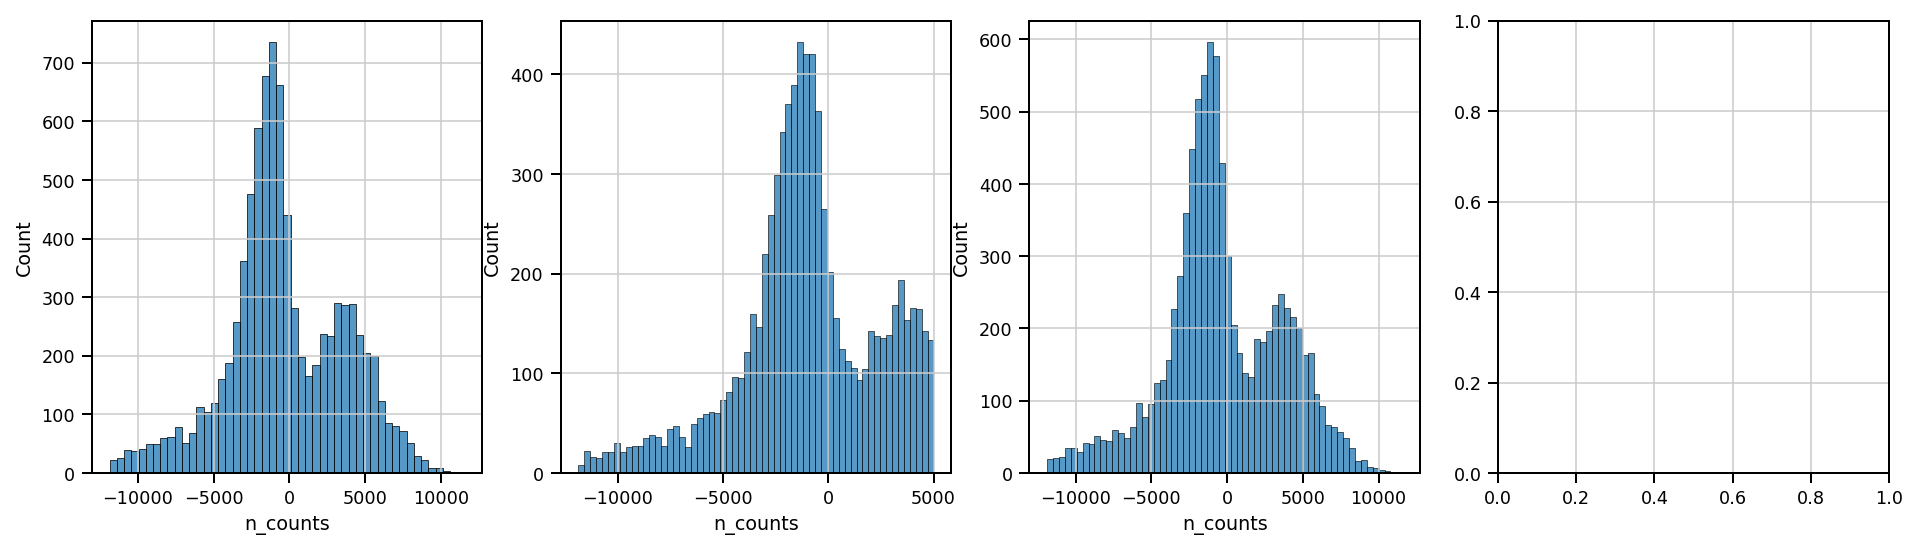

In [10]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(atac.obs['n_counts'], kde=False, ax=ax1,)
ax2_dict =  sb.histplot(atac.obs['n_counts'][atac.obs['n_counts']<5000], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(atac.obs['n_counts'][atac.obs['n_counts']<30000], kde=False, bins=60, ax=ax3,)
ax4_dict = sb.histplot(atac.obs['n_counts'][atac.obs['n_counts']>30000], kde=False, bins=60, ax=ax4, )
savefig='figures/'+samplename + '_1_QC_counts_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

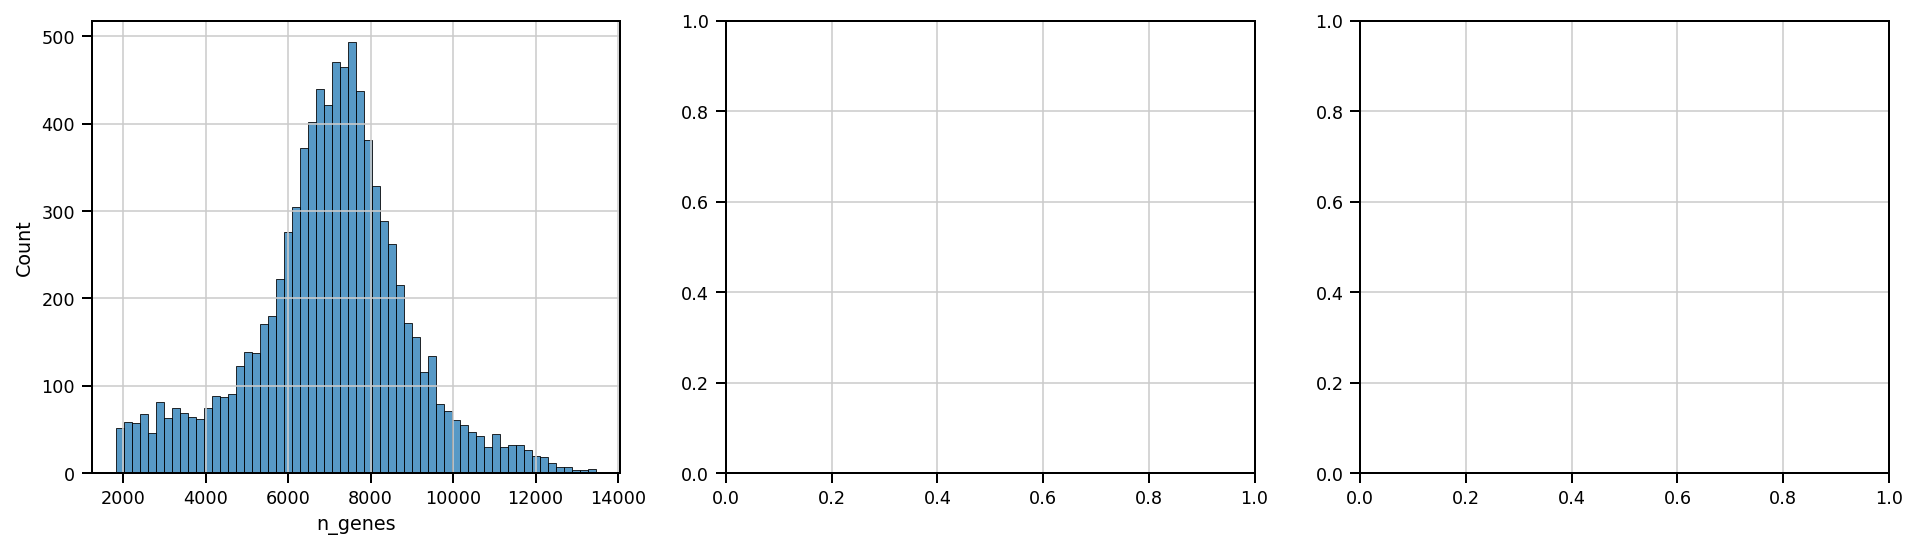

In [11]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(atac.obs['n_genes'], kde=False, bins=60, ax=ax1,)
ax2_dict =  sb.histplot(atac.obs['n_genes'][atac.obs['n_genes']<500], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(atac.obs['n_genes'][atac.obs['n_genes']<1000], kde=False, bins=60, ax=ax3,)
savefig='figures/'+samplename + '_2_QC_gene_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

In [12]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(atac.n_obs))

sc.pp.filter_cells(atac, min_counts = 4000)
print('Number of cells after min count filter: {:d}'.format(atac.n_obs))

sc.pp.filter_cells(atac, max_counts = 50000)
#print('Number of cells after max count filter: {:d}'.format(atac.n_obs))


Total number of cells: 8761
Number of cells after min count filter: 1361


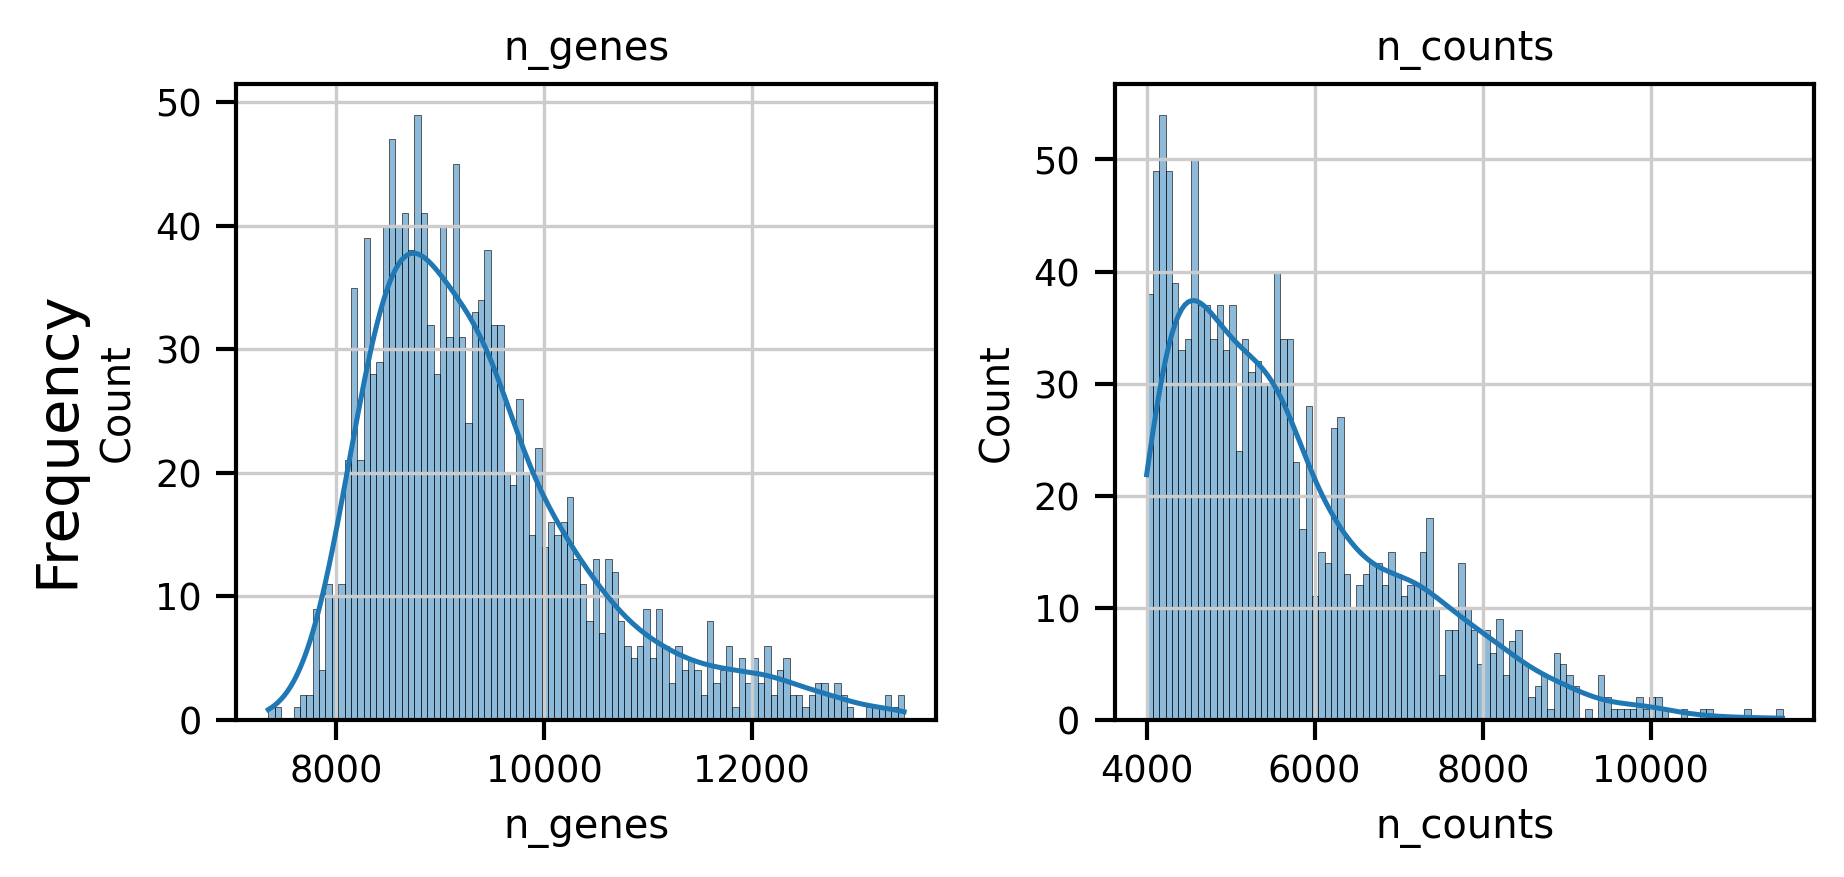

In [13]:

sb.set_context('paper')


fig, (ax1, ax2,) = pl.subplots(1, 2, figsize=(6, 3), dpi=150, sharey=False)
atac.obs['n_genes']

sb.histplot( atac.obs['n_genes'], ax=ax1, kde=True, bins=100)
sb.histplot( atac.obs['n_counts'], ax=ax2, kde=True, bins=100)

ax1.title.set_text('n_genes')
ax2.title.set_text('n_counts')

fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()
savefig='figures/'+samplename + '_3_QC_filtering_postfilter.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

... storing 'sample' as categorical
... storing 'group' as categorical


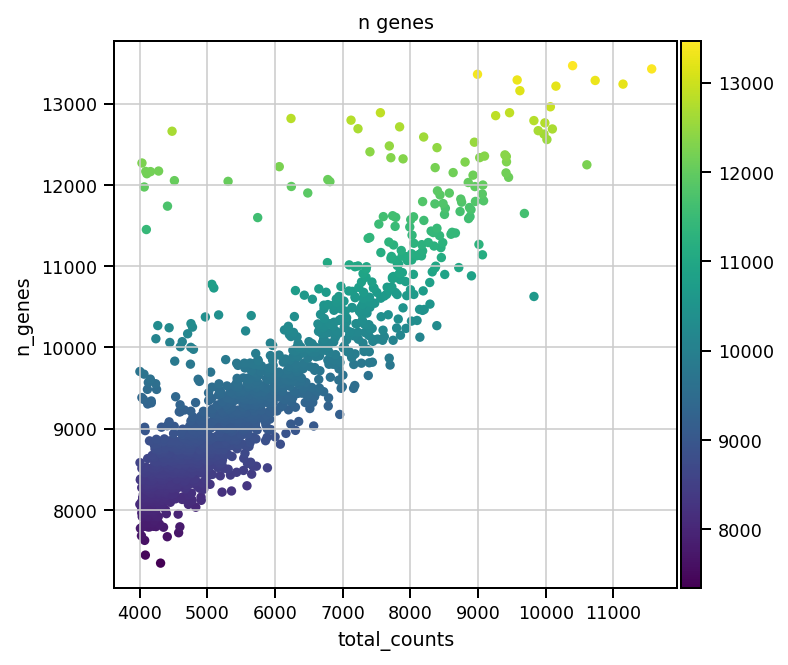

In [14]:
# plot percentage of mitochondtial genes versus count depth and n_genes
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5) #rescale figures
savefig=samplename + '_4_QC_saturationplot.pdf'
sc.pl.scatter(atac, x='total_counts', y='n_genes', color='n_genes',save=savefig)

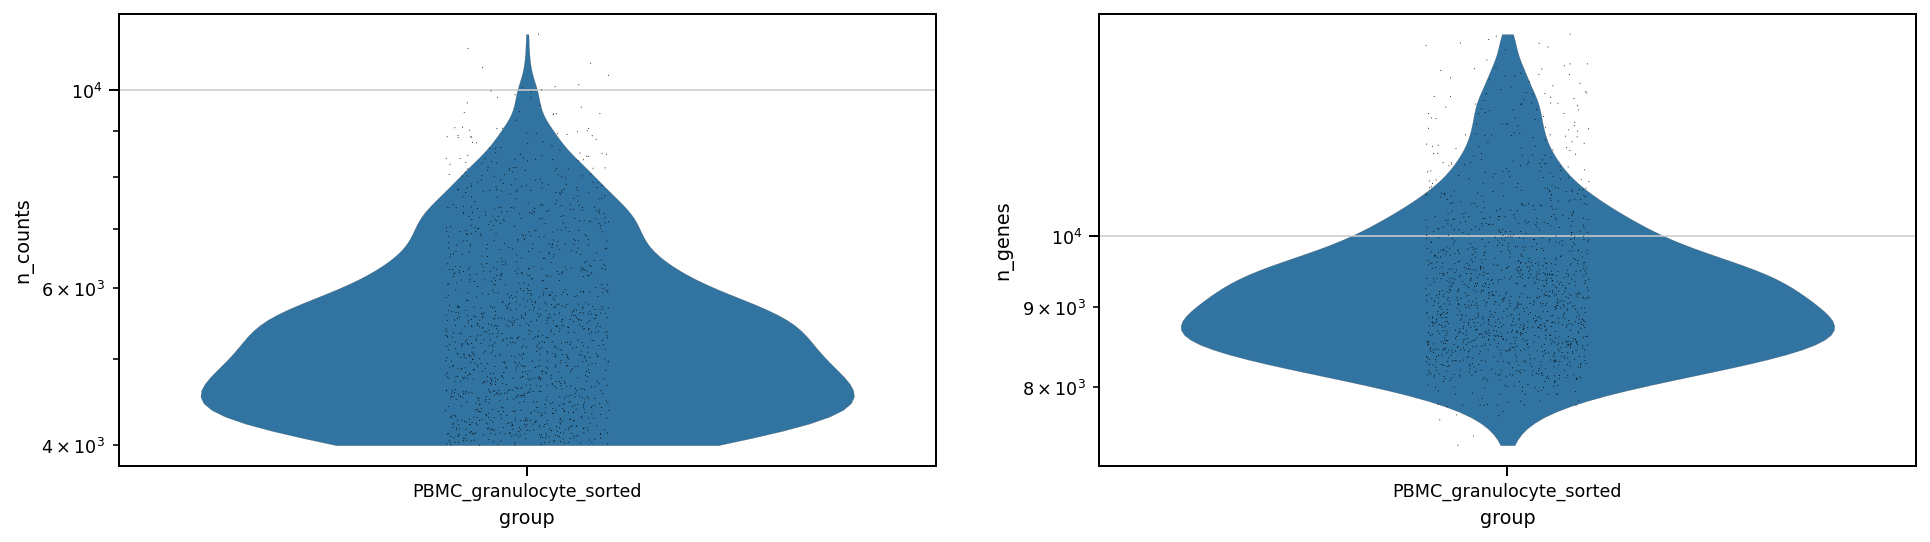

In [15]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2,) = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sc.pl.violin(atac, 'n_counts', groupby='group', size=0.5, log=True, cut=0, ax=ax1, show=False)
ax2_dict =  sc.pl.violin(atac, 'n_genes', groupby='group', size=0.5, log=True, cut=0, ax=ax2, show=False)

savefig='figures/'+samplename + '_5_QC_violin_plots.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

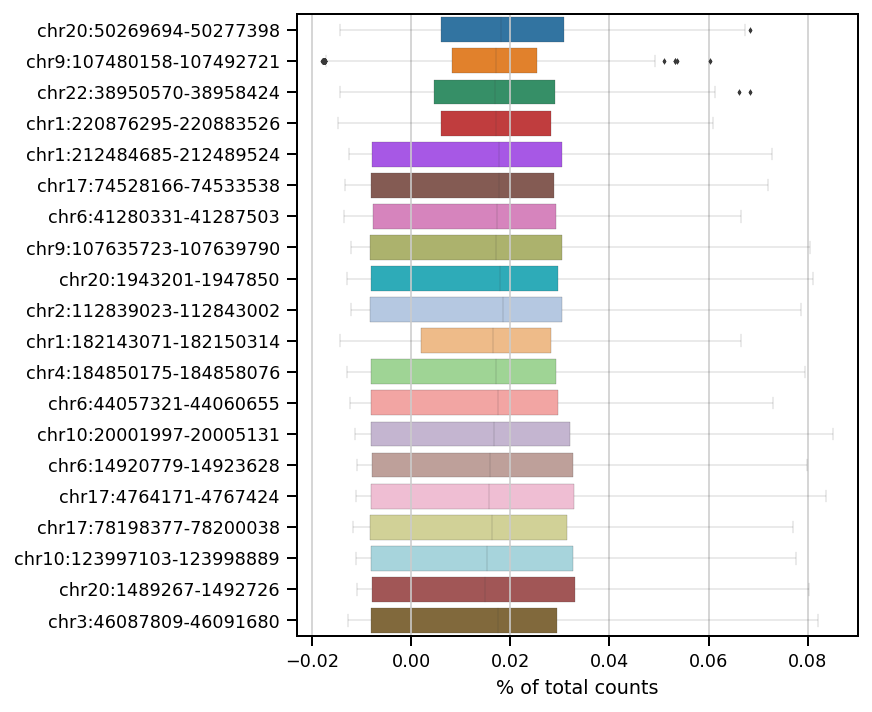

In [16]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
savefig='_'+samplename + '_6_QC_highest_expr_genes.pdf'
sc.pl.highest_expr_genes(atac, n_top=20,save=savefig,)

In [17]:
print(atac.obs['group'].value_counts())

PBMC_granulocyte_sorted    1361
Name: group, dtype: int64


In [18]:
atac.obs['n_counts'].sum()/atac.obs['group'].value_counts()

PBMC_granulocyte_sorted    5675.831007
Name: group, dtype: float64

In [19]:
atac.obs['n_counts'].sum()

7724806.0

# Nucleosome signal
Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

In [20]:
atac.obs['NS']=1

In [21]:
from muon import atac as ac

In [22]:
ac.tl.locate_fragments(atac,fragments=data_dir+'pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz')

Fetching Regions...: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


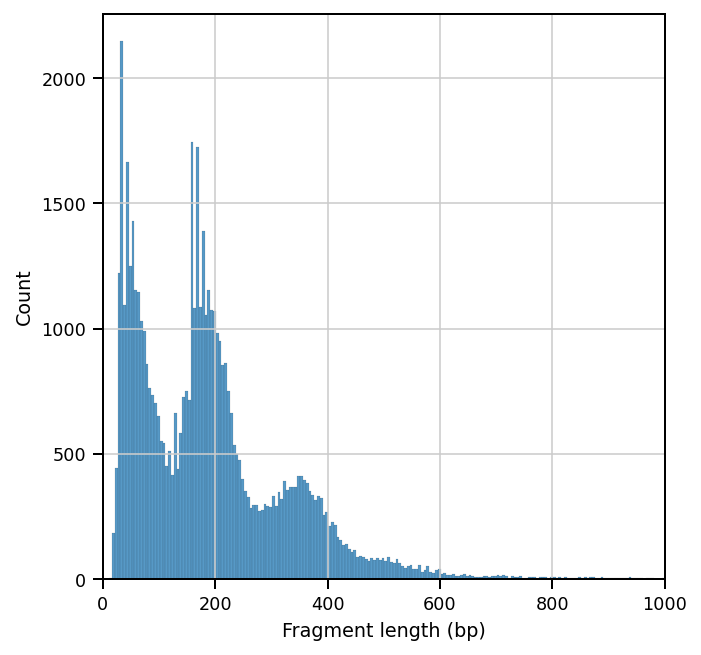

In [23]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [24]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:02<00:00, 423174.86it/s]


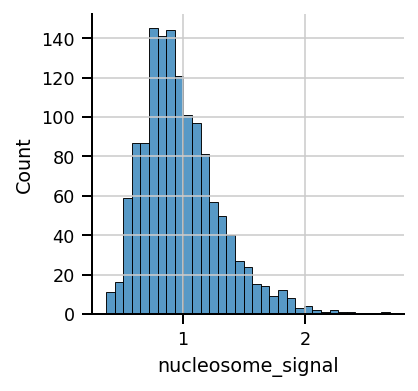

In [25]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

#TSS enrichment
We can expect chromatin accessibility enriched around transcription start sites (TSS) compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric.

The positions of transcription start sites can be obtained from the interval field of the gene annotation in the rna modality:

In [26]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
AL627309.1,chr1,120931,133723,ENSG00000238009,AL627309.1
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
AL627309.4,chr1,160445,160446,ENSG00000241599,AL627309.4


In [27]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|██████████| 1000/1000 [00:08<00:00, 117.76it/s]


In [28]:
tss

AnnData object with n_obs × n_vars = 1361 × 2001
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'leiden', 'celltype', 'leiden_joint', 'celltype_joint'
    var: 'TSS_position'

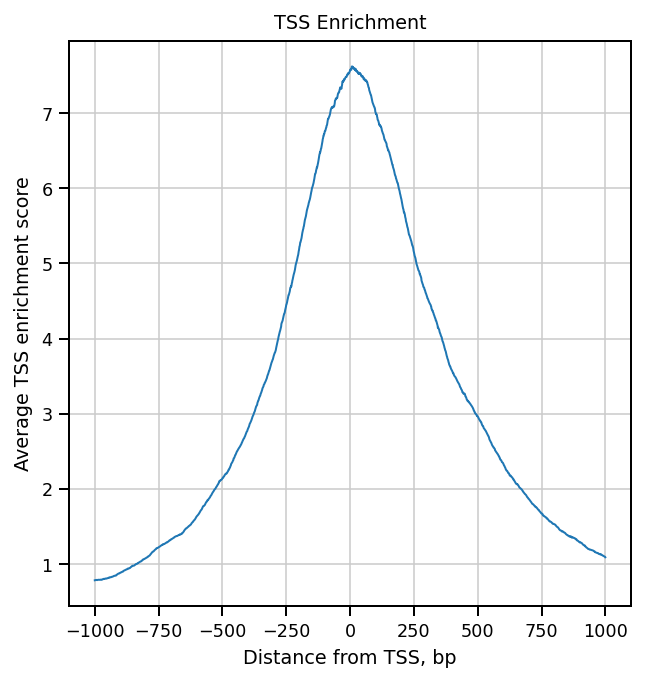

In [29]:
pl.rcParams['lines.linewidth'] = 1
ac.pl.tss_enrichment(tss)

# Normalization

In [30]:
# Save original counts
atac.layers["counts"] = atac.X

There can be multiple options for ATAC-seq data normalisation.

One is latent semantic indexing that is frequently used for processing ATAC-seq datasets. First, it constructs term-document matrix from the original count matrix. Then the singular value decomposition (SVD) — the same technique that convential principal component analysis uses — is used to generate LSI components. Note that there are different flavours of computing TF-IDF, e.g. see this blog post about that.

TF-IDF normalisation is implemented in the muon’s ATAC module:

In [31]:
ac.pp.tfidf(atac, scale_factor=1e4)

/opt/conda/lib/python3.9/site-packages/muon/_atac/preproc.py:62: RuntimeWarning: divide by zero encountered in log1p
/opt/conda/lib/python3.9/site-packages/muon/_atac/preproc.py:62: RuntimeWarning: invalid value encountered in log1p
/opt/conda/lib/python3.9/site-packages/muon/_atac/preproc.py:64: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.9/site-packages/muon/_atac/preproc.py:66: RuntimeWarning: invalid value encountered in log1p


In [32]:
atac.var

,gene_ids,feature_types,genome,interval,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
chr1:10109-10357,chr1:10109-10357,Peaks,GRCh38,chr1:10109-10357,8761,-0.004749,0.0,-41.604416,False,0.027167,1.738205,1.950642,0.010696,0.129493
chr1:180730-181630,chr1:180730-181630,Peaks,GRCh38,chr1:180730-181630,8761,-0.004434,0.0,-38.846058,False,0.049086,1.380565,0.448998,0.021353,0.176478
chr1:191491-191736,chr1:191491-191736,Peaks,GRCh38,chr1:191491-191736,8761,-0.008278,0.0,-72.520889,False,0.017277,1.531318,0.810903,0.007133,0.103504
chr1:267816-268196,chr1:267816-268196,Peaks,GRCh38,chr1:267816-268196,8761,0.002651,0.0,23.223803,False,0.031286,1.292511,-0.415543,0.013829,0.141174
chr1:586028-586373,chr1:586028-586373,Peaks,GRCh38,chr1:586028-586373,8761,0.006992,0.0,61.255924,False,0.027071,1.613337,1.262745,0.010362,0.130964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KI270713.1:20444-22615,KI270713.1:20444-22615,Peaks,GRCh38,KI270713.1:20444-22615,8761,-0.006685,0.0,-58.566727,False,0.267579,-0.646027,-0.310364,0.227387,0.274033
KI270713.1:27118-28927,KI270713.1:27118-28927,Peaks,GRCh38,KI270713.1:27118-28927,8761,-0.013382,0.0,-117.241814,False,0.077695,1.206299,0.394590,0.037643,0.220126
KI270713.1:29485-30706,KI270713.1:29485-30706,Peaks,GRCh38,KI270713.1:29485-30706,8761,-0.002582,0.0,-22.624788,False,0.084637,1.138867,0.082998,0.042117,0.229304
KI270713.1:31511-32072,KI270713.1:31511-32072,Peaks,GRCh38,KI270713.1:31511-32072,8761,0.000523,0.0,4.579499,False,0.043489,1.460675,0.425947,0.018688,0.165238


#Feature selection

In [33]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

ValueError: Found array with 0 sample(s) (shape=(0, 108377)) while a minimum of 1 is required.

In [34]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

ZeroDivisionError: division by zero

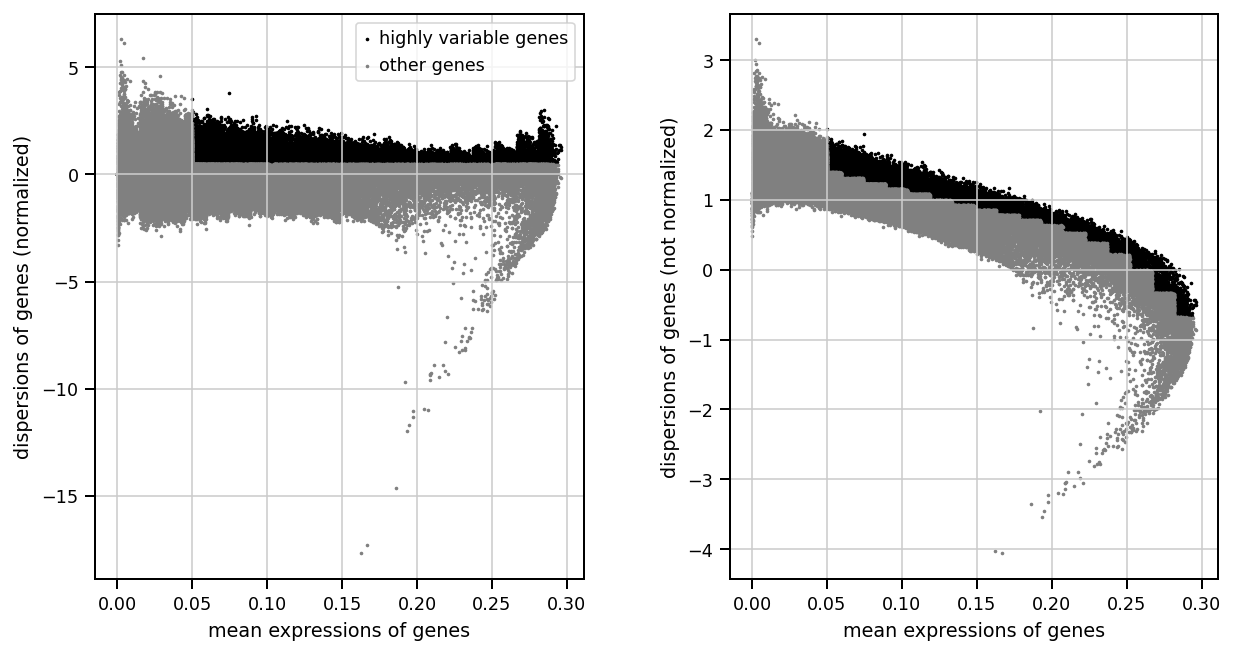

In [35]:
sc.pl.highly_variable_genes(atac)

In [36]:
np.sum(atac.var.highly_variable)

19478

# Scaling

In [37]:
atac.raw = atac

#Analysis
After filtering out low-quality cells, normalising the counts matrix, and selecting highly varianbe peaks, we can already use this data for multimodal integration.

However, as in the case of gene expression, we will study this data individually first and will run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types. This might be useful later to compare cell type definition between modalities.

In [38]:
ac.tl.lsi(atac)

ValueError: k must be between 1 and min(A.shape), k=50

In [ ]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [39]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=10)

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required by check_pairwise_arrays.

# PCA

In [ ]:
sc.pp.scale(atac)
sc.tl.pca(atac)

In [ ]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

With muon’s ATAC module, we can plot average values for cut counts in peaks of different types (promoter/distal) that are assigned to respective genes — just by providing gene names.

For that to work, we need the peak annotation table with gene -> peak correspondence. The peak_annotation.tsv file was detected and loaded automatically when we loaded the original data. Here is how the processed peak annotation table looks like:

In [ ]:
ac.tl.add_peak_annotation(atac, annotation=data_dir+"pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv")

In [ ]:
atac.uns['atac']['peak_annotation'].tail()

# Alternatively add peak annotation from a TSV file
# ac.tl.add_peak_annotation(atac, annotation="data/pbmc10k/atac_peak_annotation.tsv")

In [ ]:
ac.pl.pca(atac, color=["BCL11B", "CCR6", "KLF4"], average="total")

In [ ]:
ac.pl.pca(atac, color="BCL11B", average="peak_type")

In [ ]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

#Non-linear dimensionality reduction and clustering¶

In [ ]:
sc.tl.leiden(atac, resolution=.5)

In [ ]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

In [ ]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

In [ ]:
atac.var

#Marker genes and celltypes

In [ ]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [ ]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option("max_columns", 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

In [ ]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["10", "14", "15", "16"]))
# Analogous to
#   atac = atac[~atac.obs.leiden.isin(["10", "14", "15", "16"])]
# but doesn't copy the object

In [ ]:
new_cluster_names = {
    "1": "CD4+ memory T", "2": "CD8+ naïve T", "3": "CD4+ naïve T",
    "5": "CD8+ activated T", "8": "NK", "12": "MAIT",
    "9": "naïve B", "6": "memory B",
    "0": "intermediate mono", "4": "CD14 mono", "7": "CD16 mono",
    "11": "mDC", "13": "pDC",
}

atac.obs['celltype'] = atac.obs.leiden.astype("str").values
atac.obs.celltype = atac.obs.celltype.astype("category").cat.rename_categories(new_cluster_names)

In [ ]:
atac.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'], inplace=True)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

In [ ]:
sc.pl.umap(atac, color=["celltype"], legend_loc="on data", frameon=False)

In [ ]:
ac.pl.umap(atac)

In [ ]:
marker_genes = ['IL7R', 'TRAC',
                'GATA3',
                'SLC4A10',
                'CD8A', 'CD8B', 'CD248', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'TNFRSF13C',
                'IL4R', 'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',
                'FCGR3A', 'MS4A7', 'CST3',
                'CLEC10A', 'IRF8', 'TCF4']

In [ ]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype')

In [ ]:
mu.write("pbmc10k.h5mu/atac", atac)

In [ ]:
atac

In [ ]:
atac.obs

In [ ]:
atac.write("atac.h5ad")

In [ ]:
mu.write("atac", atac)

## Pre-process the data

In [ ]:
atac.layers["raw"] = atac.X # copy needed?
atac.layers["sqrt_norm_cellbender"] = np.sqrt(
    sc.pp.normalize_total(atac, inplace=False)["X"])

In [ ]:
sc.experimental.pp.recipe_pearson_residuals(atac,n_top_genes=3000,n_comps=100,random_state=42,inplace=True)
atac.layers["normalized"]=atac.X
sc.pp.log1p(atac)
atac.layers["logcounts"] = atac.X

atac

## Removal of Mitochondrial and Ribosomal Protein Genes

In [ ]:
ribo_genes = atac.var_names.str.startswith(("RPS","RPL"))
mito_genes = atac.var_names.str.startswith('MT-')
malat1 = atac.var_names.str.startswith('MALAT1')
remove = np.add(ribo_genes,mito_genes)
remove = np.add(remove,malat1)
kept_genes = np.invert(remove)

In [ ]:
atac = atac[:,kept_genes]

# PCA

In [ ]:
#sc.pp.scale(atac,max_value=10)

In [ ]:
#sc.pp.pca(atac, n_comps = 100, use_highly_variable =False, svd_solver = "arpack")
sc.pl.pca_variance_ratio(atac, n_pcs = 100,log=True)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(atac, n_pcs=30,n_neighbors=10,random_state=42)
#bbknn.bbknn(atac,batch_key = "donnor", neighbors_within_batch =10, n_pcs = 50)
#Save to figures (not sample specific folder)
genes_to_plot = ['n_genes','log_counts','mt_frac']
#sc.tl.tsne(atac, n_jobs=8,use_rep='X', perplexity=30) 
sc.tl.umap(atac,random_state=42)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(atac, color = genes_to_plot,ncols=2,save=savefig)

In [ ]:
%%capture
sc.tl.leiden(atac,random_state=random_state,resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(atac,random_state=random_state,resolution=1, key_added='leiden_r1')
sc.tl.leiden(atac,random_state=random_state, resolution=0.8, key_added='leiden_r0.8')
sc.tl.leiden(atac,random_state=random_state, resolution=0.5, key_added='leiden_r0.5')
sc.tl.leiden(atac,random_state=random_state, resolution=0.4, key_added='leiden_r0.4')
sc.tl.leiden(atac,random_state=random_state, resolution=0.3, key_added='leiden_r0.3')
sc.tl.leiden(atac,random_state=random_state, resolution=0.2, key_added='leiden_r0.2')

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(atac,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_lores_vst.pdf"
sc.pl.umap(atac, color=['leiden_r0.2','leiden_r0.3','leiden_r0.4'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(atac,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(atac, color=['leiden_r0.5','leiden_r0.8','leiden_r1.5'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

# Marker genes

In [ ]:
#method : {‘logreg’, ‘t-test’, ‘wilcoxon’, ‘t-test_overestim_var’} | None (default: None)
sc.tl.rank_genes_groups(atac, 'leiden_r0.5', method='t-test',n_genes=atac.shape[1])
markers=pd.DataFrame(atac.uns['rank_genes_groups']['names']).head(20)
markers

# Search for genes

In [ ]:
regex = re.compile('^(PTPRC).*', re.IGNORECASE)
genes = [l for l in atac.var_names for m in [regex.search(l)] if m]

In [ ]:
genes

#sample composition

In [ ]:
order=atac.obs['predicted'].value_counts()

In [ ]:
order.index

In [ ]:
atac.obs['predicted'].cat.categories

In [ ]:
atac.obs.predicted= atac.obs.predicted.cat.reorder_categories(['Epithelial_cells', 'T_cells', 'Tissue_stem_cells',
                  'Macrophage', 'Chondrocytes', 'Neutrophils',
                  'Pro-B_cell_CD34+'])

In [ ]:
print(atac[atac.obs['predicted'] == 'Epithelial_cells'].obs['fov'].value_counts())

In [ ]:
order=atac[atac.obs['predicted'] == 'Epithelial_cells'].obs['fov'].value_counts()

In [ ]:
order.index

In [ ]:
atac.obs['fov'].cat.categories

In [ ]:
atac.obs.fov= atac.obs.fov.cat.reorder_categories(['8', '7', '27', '28', '5', '2', '3', '12', '16', '17', '29',
                  '11', '10', '4', '26', '13', '15', '1', '30', '9', '23',
                  '19', '22', '14', '18', '20', '21', '24', '25' 
       ])

In [ ]:
 fig=plot_proportion_barplot_with_ncells(
    atac,
    'fov',
    fill='predicted', 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label='annotated',
    percent_limit=1., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0, 0.5),
    normalize_by=None,)
fig.savefig('cell_composition_by_FOV.pdf', dpi=300, bbox_inches='tight')

# SingleR

In [ ]:
atac.X=atac.X.todense()

In [ ]:
from scipy.sparse import issparse

In [ ]:
%time
predict_cell_types(atac,cluster_key='leiden_r0.5',obs_out_key='predicted',species='human',ref_label_column='label.main')

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(10,10)
umap_point_size = np.maximum(120000/atac.n_obs, 2)
#sc.tl.leiden(atac,random_state=random_state, resolution = 0.5)
savefig=samplename+"_6_predicted.pdf"
sc.pl.umap(atac, color=['predicted'], legend_loc='on data',legend_fontoutline=3,vmin='p10', vmax='p99.9',cmap=mymap, legend_fontweight='normal',size=umap_point_size,frameon=False,save=savefig)

In [ ]:
atac=sc.read('/Users/andres/Documents1/Transcriptomics/GeoMX/publicdata/Lung5_Rep2/Lung5_Rep2-Flat_files_and_images/test_predicted.h5ad')
atac

In [ ]:
atac.obs.predicted

In [ ]:
atac.obs.predicted=atac.obs.predicted.str.replace(':', '_')

In [ ]:
#method : {‘logreg’, ‘t-test’, ‘wilcoxon’, ‘t-test_overestim_var’} | None (default: None)
sc.tl.rank_genes_groups(atac, 'predicted', method='t-test',n_genes=atac.shape[1])
markers=pd.DataFrame(atac.uns['rank_genes_groups']['names']).head(20)
markers

In [ ]:
sq.pl.spatial_scatter(atac, color=["CD74", "leiden_r0.5"],library_id='23')

In [ ]:
sq.pl.spatial_segment(atac, color="CD74", library_key="fov", seg_cell_id="cell_ID",save='fov_test1.pdf')

In [ ]:
%matplotlib inline
plt.ioff()
tabs = pn.Tabs()
for fov in ['1','2','3']:
  fig=sq.pl.spatial_segment(atac, color="CD74", library_key="fov", library_id=fov,seg_cell_id="cell_ID")
  mpl_pane = pn.pane.Matplotlib(fig, dpi=144,name=fov)
  tabs.append(mpl_pane)
tabs

In [ ]:
%matplotlib inline

In [ ]:
fig=sq.pl.spatial_segment(atac, color="HLA-DRA", library_key="fov", library_id='1',seg_cell_id="cell_ID")

In [ ]:
fig=sq.pl.spatial_segment(atac, color="leiden_r0.5",groups=["0", "1"], library_key="fov", library_id='2',seg_cell_id="cell_ID",seg_outline=True,img=True, frameon=True,)

In [ ]:
fig = sc.pl.umap(atac, color='CD74',
                 sort_order=True, ncols=4, return_fig=True, color_map='Blues', use_raw=False,
                 vmin='p5', vmax='p99.9')
fig.set_size_inches(12, 12)
plt.show()

In [ ]:
sq.pl.spatial_segment(
    atac,
    color="Cluster",
    groups=["Fibroblast", "Epithelial"],
    library_key="library_id",
    seg_cell_id="cell_id",
    seg_outline=True,
    img=False,
    frameon=False,
)

In [ ]:
mpl_pane = pn.pane.Matplotlib(sq.pl.spatial_segment(atac, color="leiden_r0.5",groups=["0", "1"], library_key="fov", library_id='2',seg_cell_id="cell_ID",seg_outline=True,img=True, frameon=True,), dpi=144,name=fov)

In [ ]:
atac.obs['predicted']

In [ ]:
%matplotlib inline
sq.pl.spatial_segment(atac, color="predicted",groups=['Epithelial_cells','T_cells'], library_key="fov", library_id='2',seg_cell_id="cell_ID",seg_outline=True,img=True, frameon=True,)


In [ ]:
%matplotlib inline
sq.pl.spatial_segment(atac, color="predicted",groups=['Epithelial_cells','T_cells'], library_key="fov", seg_cell_id="cell_ID",seg_outline=True,img=True, frameon=True,save='epi_tcells_allfov.pdf')


In [ ]:
from matplotlib.figure import Figure

In [ ]:
fig = Figure(figsize=(10, 6))
ax = fig.subplots()
sq.pl.spatial_segment(atac, color="leiden_r0.5",groups=["0", "1"], library_key="fov", library_id='2',seg_cell_id="cell_ID",seg_outline=True,img=True, frameon=True,)
pn.pane.Matplotlib(fig)

In [ ]:
mpl_pane=pn.pane.Matplotlib(fig)

In [ ]:
mpl_pane

In [ ]:
fig0 = Figure(figsize=(8, 6))
ax0 = fig0.subplots()
FigureCanvas(fig0)  # not needed for mpl >= 3.1

strm = ax0.streamplot(X, Y, U, V, color=U, linewidth=2, cmap=cm.autumn)
fig0.colorbar(strm.lines)

mpl_pane = pn.pane.Matplotlib(fig0, dpi=144)
mpl_pane

In [ ]:
import param
from panel import Panel, Column
from panel.panels import HTMLPanel

In [ ]:
sq.pl.spatial_segment(atac, color="leiden_r0.5",groups=["0", "1"], library_key="fov", library_id='2',seg_cell_id="cell_ID",seg_outline=True,img=True, frameon=True,), dpi=144,name=fov)

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(10,5)

In [ ]:
%matplotlib inline
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5)
fig=plot_proportion_barplot_with_ncells(
    atac,
    'fov',
    fill='leiden_r0.5', 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label='annotated',
    percent_limit=1., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0, 0.5),
    normalize_by=None,)
fig.savefig('cell_composition_by_FOV2.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig=plot_proportion_barplot(
    atac,
    'fov',
    fill='predicted', 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label='annotated',
    percent_limit=1., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0.1, 0.5),
    normalize_by=None,)


In [ ]:
fig

In [ ]:
 fig1=plot_proportion_barplot_with_ncells(atac, 'fov',fill='predicted', )

In [ ]:
%matplotlib auto
plt.ioff()
sb.set_context('paper')
pl.rcParams['figure.figsize']=(10,5)
tabs = pn.Tabs()
for leiden in ['leiden_r0.2', 'leiden_r0.3','leiden_r0.4', 'leiden_r0.5','leiden_r0.8', 'leiden_r1','leiden_r1.5']:
  fig=plot_proportion_barplot_with_ncells(atac, 'fov',fill=leiden, )
  mpl_pane = pn.pane.Matplotlib(fig, dpi=144,name=leiden)
  tabs.append(mpl_pane)
tabs

In [ ]:
mpl_pane1=pn.pane.Matplotlib(fig1,dpi=144)

In [ ]:
tabs.append(mpl_pane1)
tabs

In [ ]:

tabs = pn.Tabs()
tabs.append(mpl_pane)
tabs

In [ ]:
fig=sq.pl.spatial_segment(atac, color="CD74", library_key="fov", library_id='1',seg_cell_id="cell_ID")

In [ ]:
fig.show()

In [ ]:
sq.pl.spatial_segment(atac, color="CD74", library_key="fov", library_id="19",seg_cell_id="cell_ID",save='fov_test2.pdf')

In [ ]:
sq.pl.spatial_segment(
    atac,
    color="Cluster",
    library_key="fov",
    library_id="19",
    seg_cell_id="cell_ID",
    seg_contourpx=10,
    crop_coord=[(0, 0, 300, 300)],
)

In [ ]:
sq.pl.spatial_scatter(atac, color=["CD74", "fov"],library_id='1',cmap=mymap,img=False,)

In [ ]:
atac

In [ ]:
sq.pl.spatial_scatter(
    atac,library_key='spatial',library_id=['1'],img=False,
    color=["CD74", "leiden_r0.5"],
    crop_coord=[(1500, 1500, 3000, 3000)],
    scalebar_dx=3.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
)

In [ ]:
sc.pl.spatial(atac, color="leiden_r0.5", library_id='1',spot_size=0.5,img=False)

In [ ]:
sq.gr.spatial_neighbors(atac, coord_type="generic")

In [ ]:
sq.gr.spatial_neighbors(atac, coord_type="generic")
sq.gr.nhood_enrichment(atac, cluster_key="leiden_r0.5")
sq.pl.nhood_enrichment(atac, cluster_key="leiden_r0.5", method="ward")

In [ ]:
atac.obs_keys

In [ ]:
sq.pl.spatial_segment(atac, color="leiden_r0.5", library_key="fov", seg_cell_id="cell_ID")

In [ ]:
sq.pl.spatial_segment(
    atac,
    color="leiden_r0.5",
    groups=["0","1"],
    library_key="fov",
    seg_cell_id="cell_ID",
    seg_outline=True,
    img=False,
    frameon=False,
)

In [ ]:
sc.pl.spatial(
    atac,
    color="leiden_r0.5",
    groups=[
        "Endothelium",
        "Haematoendothelial progenitors",
        "Allantois",
        "Lateral plate mesoderm",
        "Intermediate mesoderm",
        "Presomitic mesoderm",
    ],
    spot_size=0.03,
)

In [ ]:
atac = mdata.mod['atac']
atac